In [285]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [312]:
def read_events(fname):
    events = []

    with open(fname, 'r') as f:
        begin_time = np.nan
        solve_time = np.nan
        for line in f:
            entries = line.split("|")
            # Python version uses '|', too
            entries = entries[:4] + ["|".join(entries[4:])]

            (time_stamp,
             level,
             logger,
             function,
             msg) = [s.strip() for s in entries]

            if (logger, function) == ("fipy.solvers", "<module>"):
                pass
            elif (level, logger, function) == ("INFO", "fipy", "<module>"):
                versions = json.loads(msg)
                # fix name collision
                versions["solver_suite"] = versions["solver"]
                del versions["solver"]
            elif (level, function) == ("DEBUG", "<module>"):
                state = json.loads(msg)
                state["time_stamp"] = time_stamp
                state["solver_class"] = logger.split('.')[-1]
                state.update(versions)
                events.append(state.copy())
                # if state["state"] == "START":
                # elif state["state"] == "END"
            elif (level, function) == ("DEBUG", "_setConvergence"):
                state["state"] = "SWEEP"
                event = json.loads(msg)
                event.update(state)
                event["time_stamp"] = time_stamp
                event["solver_class"] = logger.split('.')[-1]
                event["solve_time"] = str(solve_time)
                events.append(event)
            elif (level, function) == ("DEBUG", "_solve_"):
                if msg == "BEGIN solve":
                    begin_time = pd.to_datetime(time_stamp)
                    # print("begin", time_stamp, begin_time)
                    solve_time = np.nan
                elif msg == "END solve":
                    solve_time = pd.to_datetime(time_stamp) - begin_time
                    # print("end", time_stamp, solve_time)
                    begin_time = np.nan

    return events

def events2df(events):
    df = pd.json_normalize(events)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df.loc[df["preconditioner"].isna()
           | (df["preconditioner"] == "NoneType"), "preconditioner"] = "unpreconditioned"

    return df

def extract_total_times(df):
    df2 = df[df["state"].isin(["START", "END"])].copy()
    df2["time_delta"] = df2["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[df2["state"] == "END"].sort_values("numberOfElements")

def extract_sweep_times(df):
    df2 = df.copy()
    df2["time_delta"] = df["time_stamp"].diff()
    df2["elapsed_seconds"] = df2["time_delta"] / pd.Timedelta("00:00:01")

    return df2[~df2["state"].isin(["START", "END"])]

In [327]:
def plot_all(df):
    fig, ax = plt.subplots(figsize=(8,6))
    for label, group in df.groupby(["solver_suite", "solver_class", "preconditioner"]):
        group.plot("numberOfElements", "elapsed_seconds", loglog=True,
                   ax=ax, label=label)
    plt.legend(bbox_to_anchor=(1., 1.))
    plt.ylabel("elapsed time / s")
    plt.xlabel("number of elements")

def plot_by_solver(df):
    for solver_class, group1 in df.groupby(["solver_class"]):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["solver_suite", "preconditioner"]):
            group2.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
        plt.legend()
        plt.title(solver_class)
        plt.ylabel("elapsed time / s")
        plt.xlabel("number of elements")

def plot_sweep_times(df):
    for numberOfElements, group1 in df.groupby("numberOfElements"):
        fig, ax = plt.subplots(figsize=(8,6))
        for label, group2 in group1.groupby(["solver_suite", "solver_class", "preconditioner"]):
            group2 = group2.reset_index()
            group2.plot(y="elapsed_seconds", ax=ax, label=label, logy=True)
        _ = plt.xlim(xmax=9)
        plt.legend(loc="upper right", bbox_to_anchor=(1.7, 1.0))
        plt.title("size = {0}x{0}".format(int(np.sqrt(numberOfElements))))
        plt.ylabel("sweep time / s")
        plt.xlabel("sweep")        

## macOS

In [321]:
macos = events2df(read_events("macos.log"))
macos_total = extract_total_times(macos)

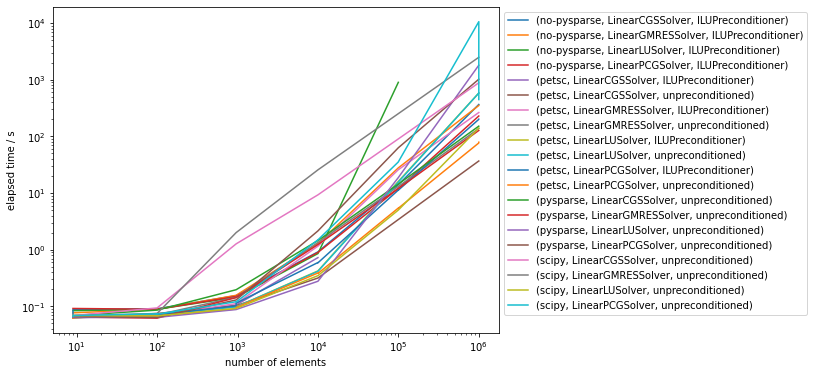

In [322]:
plot_all(macos_total)

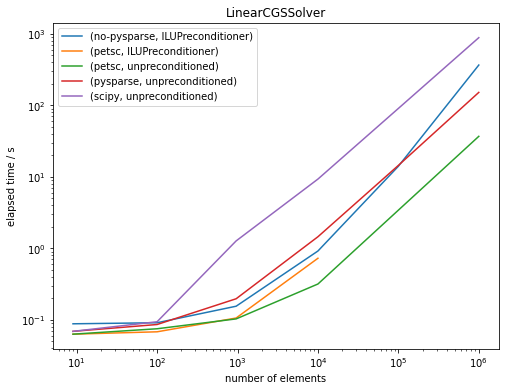

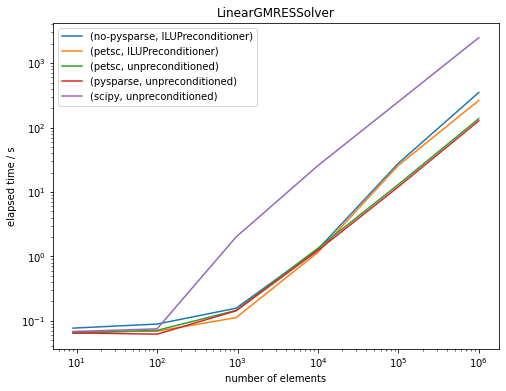

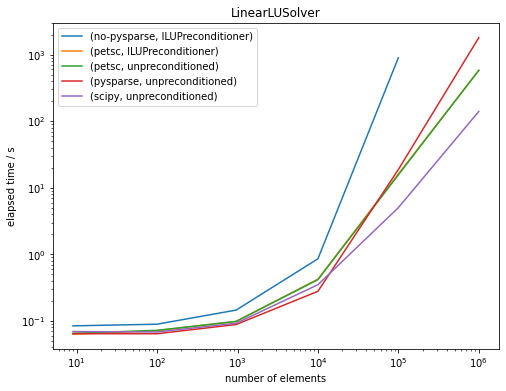

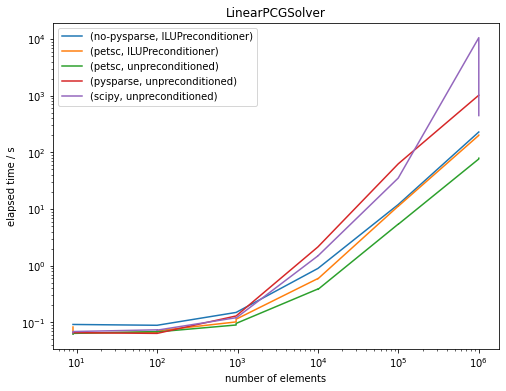

In [323]:
plot_by_solver(macos_total)

In [324]:
macos_sweep = extract_sweep_times(macos)

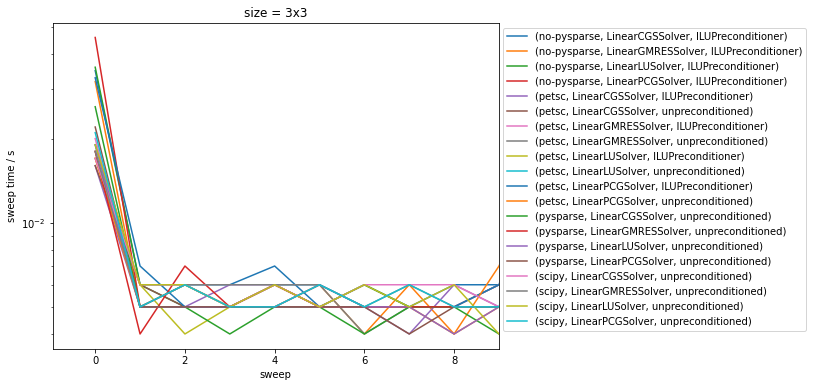

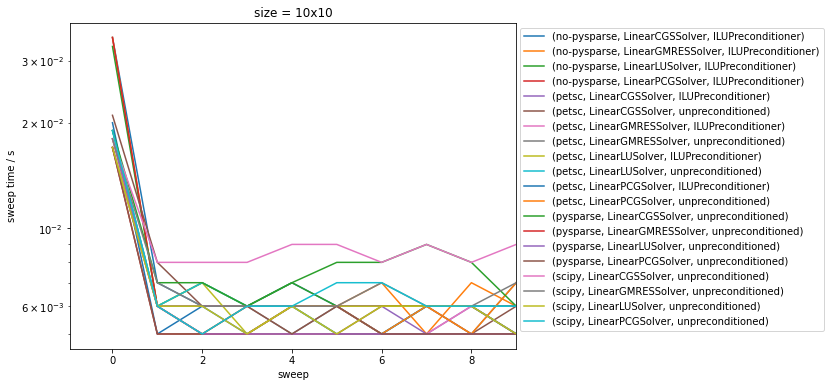

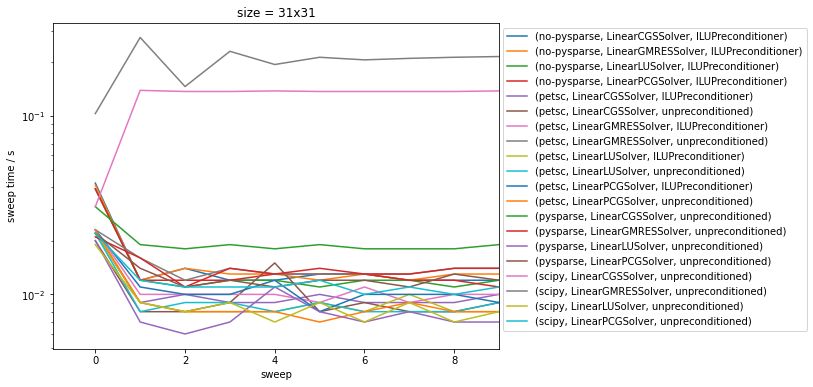

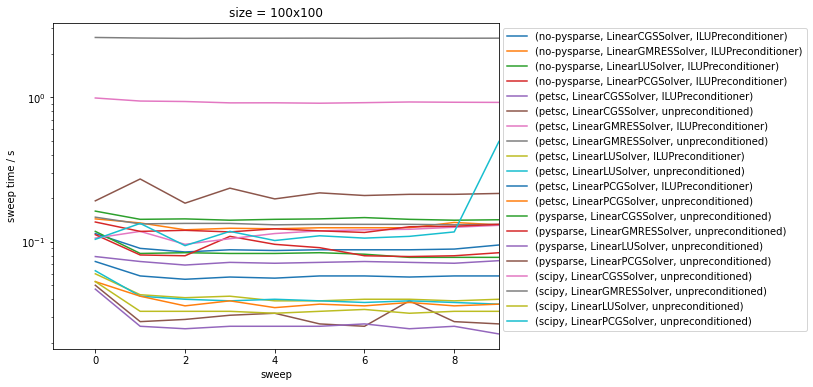

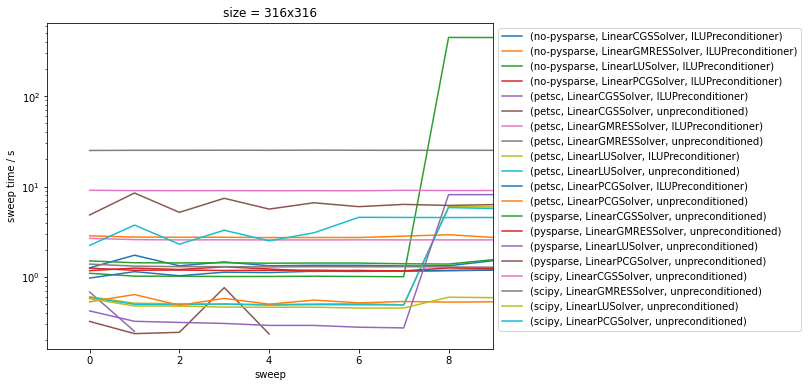

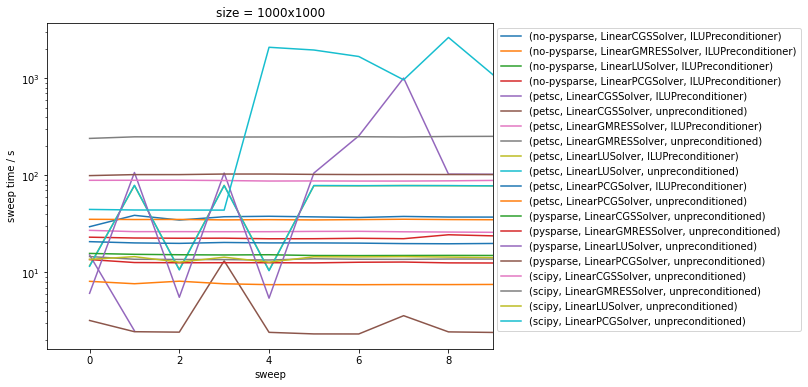

In [328]:
plot_sweep_times(macos_sweep)

## GPUs

In [329]:
gpu = events2df(read_events("gpu.log"))
gpu_total = extract_total_times(gpu)

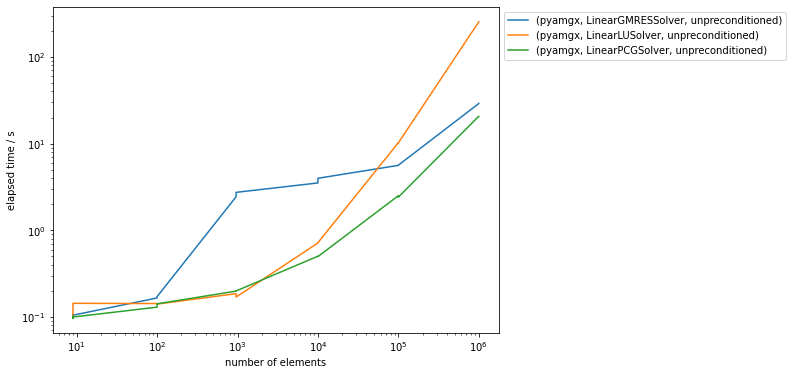

In [330]:
plot_all(gpu_total)

In [331]:
gpu_sweep = extract_sweep_times(gpu)

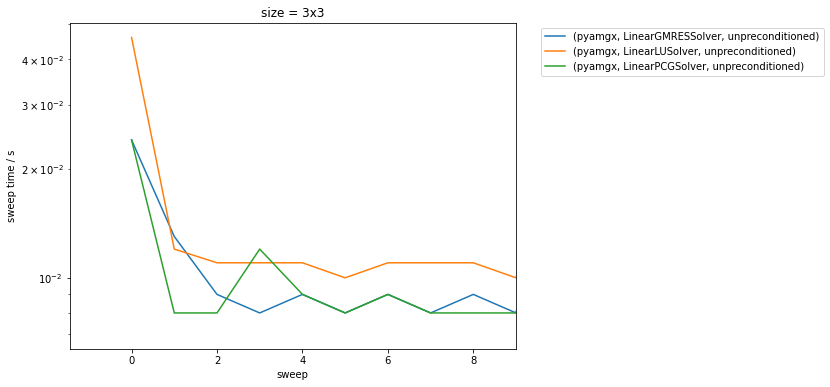

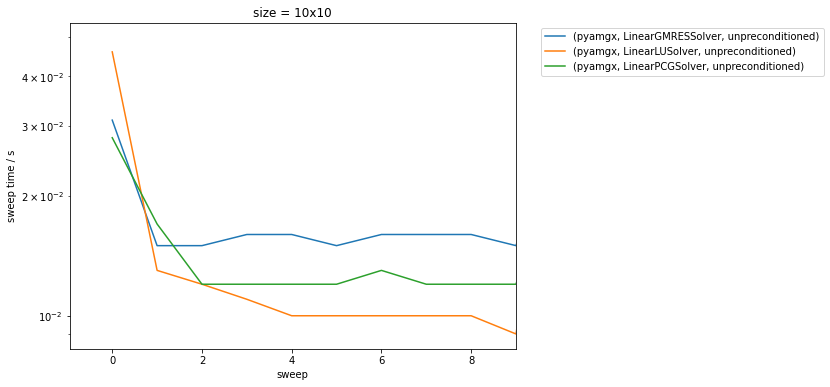

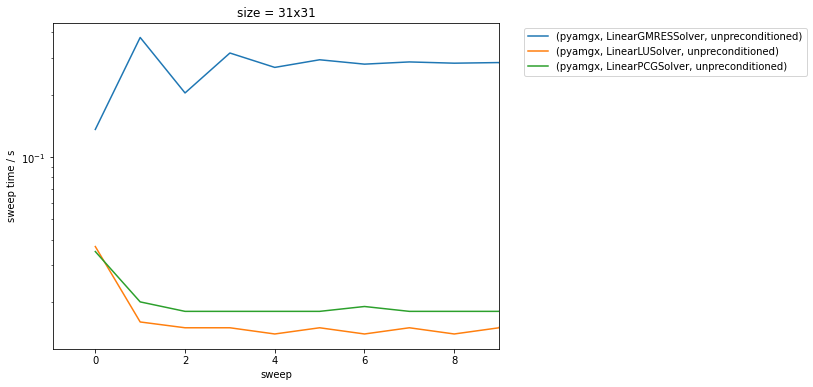

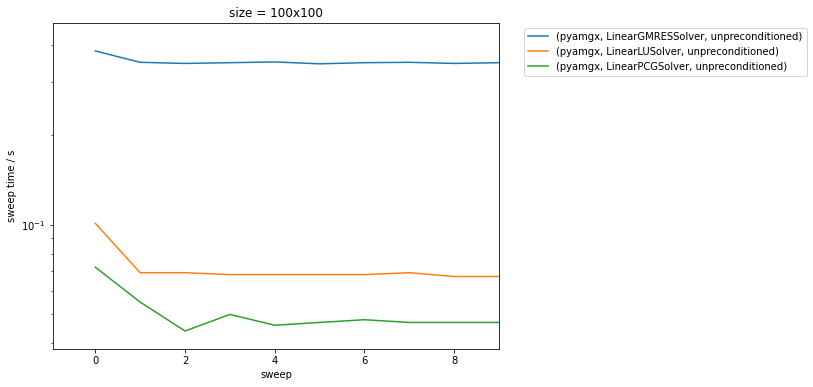

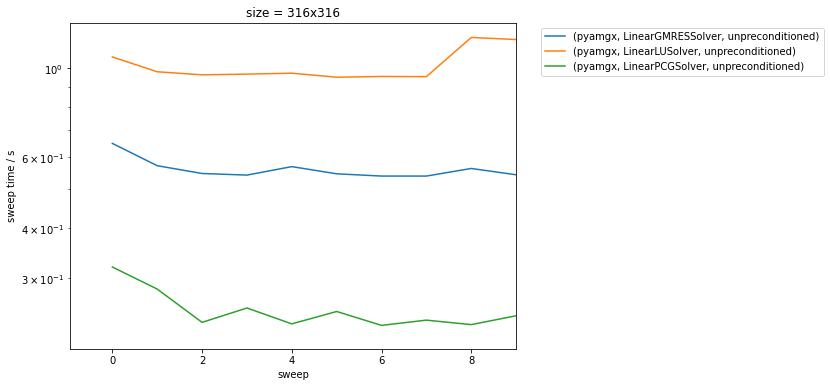

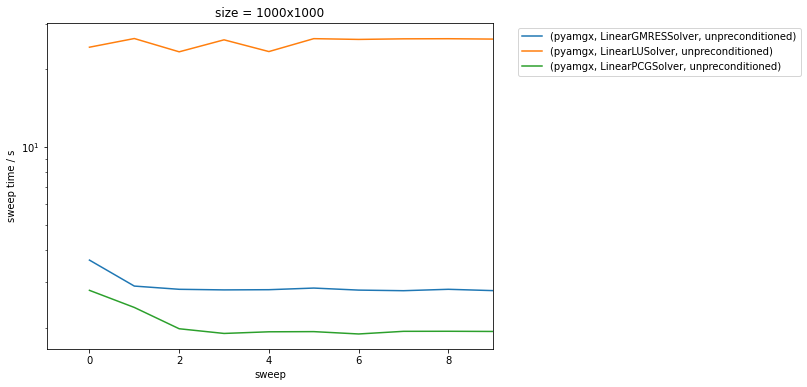

In [332]:
plot_sweep_times(gpu_sweep)

## Linux

In [333]:
events = []
for fname in glob.glob("linux2/linux.*.log"):
    events.extend(read_events(fname))

linux = events2df(events)
linux_total = extract_total_times(linux)

In [311]:
linuxdf

,state,numberOfElements,sweeps,preconditioner,time_stamp,solver_class,python,fipy,numpy,pysparse,...,actual_code,status_name,status_code,max_iterations,ksp_solver,ksp_precon,ksp_norm_type,solve_time,time_delta,elapsed_seconds
1,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.255,LinearCGSSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,cgs,none,2.0,0 days 00:00:00,0 days 00:00:00.034000,0.034
2,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.267,LinearCGSSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,cgs,none,2.0,0 days 00:00:00,0 days 00:00:00.012000,0.012
3,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.277,LinearCGSSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,cgs,none,2.0,0 days 00:00:00,0 days 00:00:00.010000,0.010
4,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.288,LinearCGSSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,cgs,none,2.0,0 days 00:00:00.001000,0 days 00:00:00.011000,0.011
5,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.298,LinearCGSSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,cgs,none,2.0,0 days 00:00:00,0 days 00:00:00.010000,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.338,LinearGMRESSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,gmres,none,2.0,0 days 00:00:00,0 days 00:00:00.010000,0.010
273,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.347,LinearGMRESSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,gmres,none,2.0,0 days 00:00:00,0 days 00:00:00.009000,0.009
274,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.357,LinearGMRESSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,gmres,none,2.0,0 days 00:00:00,0 days 00:00:00.010000,0.010
275,SWEEP,9,10,unpreconditioned,2022-07-15 10:53:46.366,LinearGMRESSolver,"3.10.5 | packaged by conda-forge | (main, Jun ...",3.4.3+110.g520c449b,1.23.0,not installed,...,2.0,KSP_CONVERGED_RTOL,2.0,1000.0,gmres,none,2.0,0 days 00:00:00,0 days 00:00:00.009000,0.009


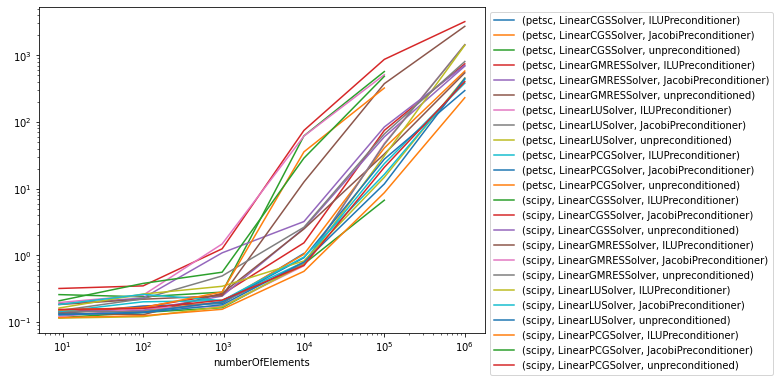

In [294]:
fig, ax = plt.subplots(figsize=(8,6))
for label, group in linuxdf.groupby(["solver_suite", "solver_class", "preconditioner"]):
    group.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
plt.legend(bbox_to_anchor=(1., 1.))

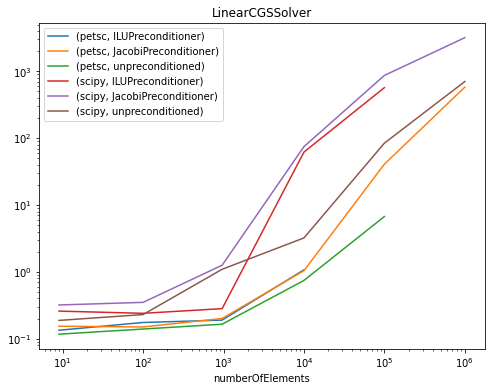

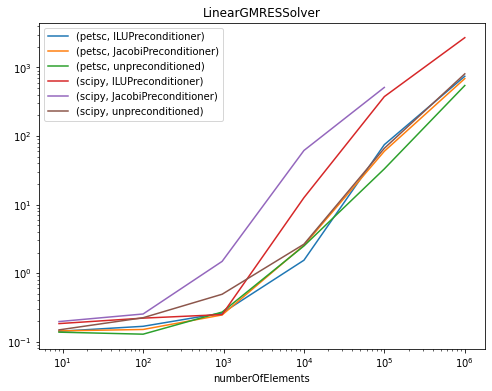

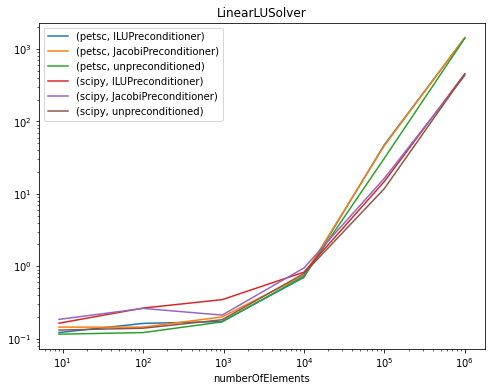

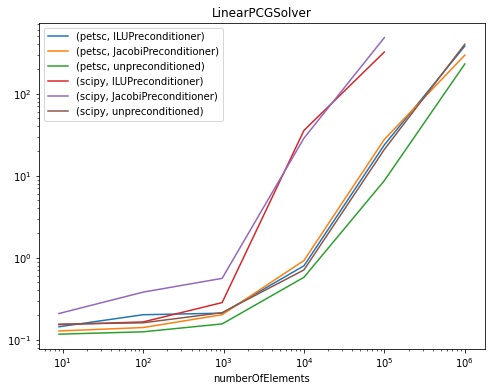

In [295]:
for solver_class, group1 in linuxdf.groupby(["solver_class"]):
    fig, ax = plt.subplots(figsize=(8,6))
    for label, group2 in group1.groupby(["solver_suite", "preconditioner"]):
        group2.plot("numberOfElements", "elapsed_seconds", loglog=True, ax=ax, label=label)
    plt.legend()
    plt.title(solver_class)

## Compare solutions

In [220]:
import numpy as np

from matplotlib import pyplot as plt

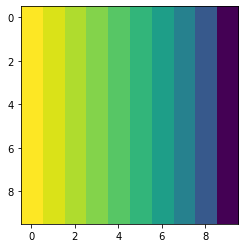

In [237]:
x10, y10, var10x10 = np.loadtxt("gpu/pyamgx/LinearGMRESSolver/100/solution.tsv", skiprows=1, unpack=True)
var10x10 = var10x10.reshape((10,10))
plt.imshow(var10x10)

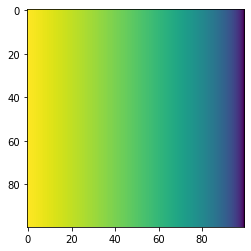

In [238]:
x100, y100, var100x100 = np.loadtxt("gpu/pyamgx/LinearGMRESSolver/10000/solution.tsv", skiprows=1, unpack=True)
var100x100 = var100x100.reshape((100,100))
plt.imshow(var100x100)

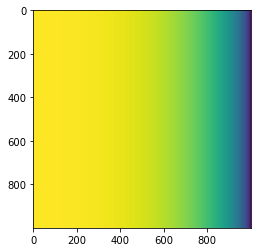

In [239]:
x1000, y1000, var1000x1000 = np.loadtxt("gpu/pyamgx/LinearGMRESSolver/1000000/solution.tsv", skiprows=1, unpack=True)
var1000x1000 = var1000x1000.reshape((1000,1000))
plt.imshow(var1000x1000)

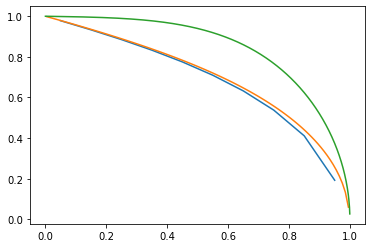

In [246]:
plt.plot(x10[:10], var10x10[0, ...])
plt.plot(x100[:100], var100x100[0, ...])
plt.plot(x1000[:1000], var1000x1000[0, ...])

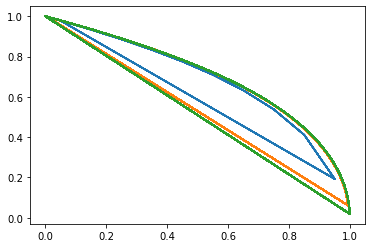

In [316]:
plt.plot(x10, var10x10.flat)
plt.plot(x100, var100x100.flat)
plt.plot(x1000, var1000x1000.flat)

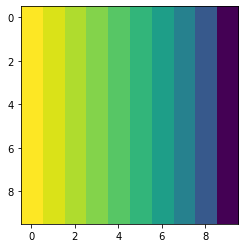

In [247]:
x10, y10, var10x10 = np.loadtxt("gpu/pyamgx/LinearPCGSolver/100/solution.tsv", skiprows=1, unpack=True)
var10x10 = var10x10.reshape((10,10))
plt.imshow(var10x10)

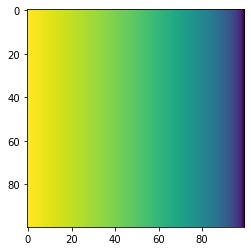

In [248]:
x100, y100, var100x100 = np.loadtxt("gpu/pyamgx/LinearPCGSolver/10000/solution.tsv", skiprows=1, unpack=True)
var100x100 = var100x100.reshape((100,100))
plt.imshow(var100x100)

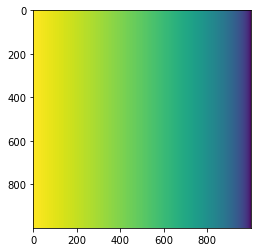

In [249]:
x1000, y1000, var1000x1000 = np.loadtxt("gpu/pyamgx/LinearPCGSolver/1000000/solution.tsv", skiprows=1, unpack=True)
var1000x1000 = var1000x1000.reshape((1000,1000))
plt.imshow(var1000x1000)

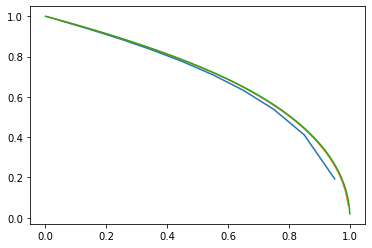

In [250]:
plt.plot(x10[:10], var10x10[0, ...])
plt.plot(x100[:100], var100x100[0, ...])
plt.plot(x1000[:1000], var1000x1000[0, ...])

In [242]:
var10x10[..., 0].shape

(10,)

31.0